# Predict low-risk profitable trading opportunity with high frequency trading data

## Team members: <br />
* 梁康华 1601213555<br />
* 李君涵 1601213559<br />
* 纪雪云 1601213544<br />
* 王昊炜 1601213612

## 0. Import Packages

In [58]:
#Switch to '/evanleungc/PHBS_TQFML/Project/Code' Repository becuase some classes and functions are in the directory
import os
os.chdir('/Users/apple/Documents/PHBS_TQFML/Project/Code')
import numpy as np
import pandas as pd
import os
import feature_funcs as ff
from HfqShare.Feature import Feature
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.optimizers
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

## 1.Motivation

* In the study of market microstructure, many researches prove that people with private information will buy and sell before non-informed traders.
* These traders tend to generate abnormal trading volume or price fluctuation in the market.
* High frequency data is a more precise and instant catch of these change and behavior.
* These behavior may generate complicated pattern and our team will attempt to employ machine learning algorithms to find these patterns and exploit profitable opportunity.

## 2. Data Description

* The dataset we used in this project consists of two basic dataset:
* (1)**High Frequency Trading Volume Dataset**. It is collected by webspider from Sina Finance, which is a level-2 data consisting the 'Active Buy' or 'Active Sell' high frequency data
* (2)**5-min Frequency Trading Data**. It is collected in wind, which consists open, high, low ,close, trading volume and trading amount in 5-min frequency level
* We will combine these two basic dataset as the high frequency dataset we use in this project
* All A-Stocks in China are included

## 3. Feature Generation

### 3.1. Generate 5-min Features
The following part will show how we generate feautres based on the 5-min frequency dataset. [See descriptions](#jump_1)

In [7]:
#Switch to '/Data' repository to get data
current_path = os.getcwd()
data_path = os.path.dirname(os.getcwd()) + '/Data/'

In [ ]:
path = data_path + 'Stk_5F_2018/Stk_5F_2018/'
funcs = Feature(path)
funcs.apply_feature(feature_name = ['buyprice', 'high', 'low', 'canbuy', 'growth_rate', 'amplitude', 'above_mean'],\
	intra = (ff.get_buy, ff.get_high, ff.get_low, ff.get_canbuy, ff.growth_rate, ff.amplitude, ff.above_mean))
df1 = funcs.gen_train_data()
path = path + 'Stk_5F_2017/Stk_5F_2017/'
funcs = Feature(path)
funcs.apply_feature(feature_name = ['buyprice', 'high', 'low', 'canbuy', 'growth_rate', 'amplitude', 'above_mean'],\
	intra = (ff.get_buy, ff.get_high, ff.get_low, ff.get_canbuy, ff.growth_rate, ff.amplitude, ff.above_mean))
df2 = funcs.gen_train_data()
df = pd.concat([df1,df2])
lag = 2
df = ff.take_lag(df, 'buyprice', lagnum = lag)
df = ff.take_lag(df, 'buyprice', lagnum = 1)
df = ff.take_lag(df, 'canbuy', lagnum = lag)
df['target'] = [0 for i in range(len(df))]
df['buyret'] = df['high'] / df['lag_%s_buyprice'%lag] - 1
df['risk'] = df['low'] / df['lag_%s_buyprice'%lag] - 1
df['target'][(df['buyret'] > 0.03) & (df['risk'] > -0.02) & (df['lag_%s_canbuy'%lag] == 1)] = 1

<span id="jump_1">The following is the key variables description</span>

In [45]:
df.tail()

,above_mean,amplitude,buyprice,canbuy,code,date,growth_rate,high,lag_1_code,low,lag_2_buyprice,lag_1_buyprice,lag_2_canbuy,target,buyret,risk
119545,0.0,0.070301,44.76,0.0,300740,2018-02-22,0.040930,44.76,300740.0,41.82,36.99,40.69,0.0,0,0.210057,0.130576
119546,0.0,0.160664,43.68,1.0,300740,2018-02-23,-0.108207,48.98,300740.0,42.20,40.69,44.76,0.0,0,0.203736,0.037110
119547,1.0,0.097967,47.52,1.0,300740,2018-02-26,0.091959,47.52,300740.0,43.28,44.76,43.68,0.0,0,0.061662,-0.033065
119548,0.0,0.081350,48.20,1.0,300740,2018-02-27,0.008228,49.98,300740.0,46.22,43.68,47.52,1.0,1,0.144231,0.058150
119549,0.0,0.046582,47.10,1.0,300740,2018-02-28,0.007739,48.08,300740.0,45.94,47.52,48.20,1.0,0,0.011785,-0.033249


* **buyprice:** It is the highest price in the last 20 miniutes of a trading day. We are going to assume we buy at this price.
* **canbuy:** If the stock has reached the price ceiling or floor, we assume that we cannot buy this stock and the variable will be 0. Otherwise, we assume that we can buy this stock and the variable will be 1. When doing the training, we will exclude all the samples with canbuy == 0.
* **buyret:** The return of buying at buyprice and sell in the highest price in the next two days.
* **risk:** The loss of buying at buyprice and sell in the lowest price in the next two days.
* **target:** The training target we use in this project. If in next twodays, the buyret > 0.03 and risk < -0.02, we consider it as a low-risk profitable trading opportunity and we set the label to be 1. Otherwise, we set it to be 0. 

Within the variables, there are two features we construct from the 5-min frequency data
* **amplitude:** This feature equals to (daily highest price/daily lowest price - 1), to measure the stock's variation. 
* **above_mean:** It is an indicator, which equals to 1 if closing price is higher than the mean price at closing time, and 0 otherwise.

### 3.2. Generate High-Frequency Features
[See Descriptions](#jump_2)

In [ ]:
hfqpath = data_path + 'group_data/'
hfqamount = pd.DataFrame()
for i in os.listdir(hfqpath):
    if i[0:5] == 'group':
        hfqamount = hfqamount.append(pd.read_csv(hfqpath + i, index_col = 0))
lag = 2
hfqamount['code'] = hfqamount['code'].map(ff.convert_stock)
hfqamount = hfqamount.drop('pchange_whole', axis = 1)
df['code'] = df['code'].map(ff.convert_stock)
df['date'] = df['date'].map(ff.convert_date)
mergedf = pd.merge(df, hfqamount, on = ['code', 'date'], how = 'left')
traindf = mergedf.dropna()
traindf = traindf.sort_values(['code', 'date'])
traindf = ff.take_lag(traindf, 'code')
traindf = traindf.sort_values(['code', 'date'])
traindf = traindf[traindf['code'] == traindf['lag_1_code']]
traindf = ff.take_forward(traindf, 'code', fnum = lag)
traindf = traindf.sort_values(['code', 'date'])
traindf = traindf[traindf['code'] == traindf['f_%s_code'%lag]]
traindf = ff.take_forward(traindf, 'target', fnum = lag)
traindf['f_%s_target'%lag][traindf['canbuy'] == 0] = np.nan
traindf = traindf.sort_values(['code', 'date'])
days = 3
for i in range(1, days + 1):
    for j in range(8):
        traindf = ff.take_lag(traindf, 'buy_vol_%s'%j, i)
        traindf = ff.take_lag(traindf, 'sell_vol_%s'%j, i)
    traindf = ff.take_lag(traindf, 'sumbuy', i)
    traindf = ff.take_lag(traindf, 'sumsell', i)

for i in range(1, days + 1):
    traindf = ff.take_lag(traindf, 'code', lagnum = i)
for i in range(1, days + 1):
    traindf = traindf[traindf['code'] == traindf['lag_%s_code'%i]]

features = []
features.append('pchange')
for i in range(8):
    traindf['buy_rate_%s'%i] = traindf['buy_vol_%s'%i] / traindf['sumsell']
    features.append('buy_rate_%s'%i)
for i in range(8):
    traindf['sell_rate_%s'%i] = traindf['sell_vol_%s'%i] / traindf['sumbuy']
    features.append('sell_rate_%s'%i)
traindf['total_rate'] = traindf['sumbuy'] / traindf['sumsell']
features.append('total_rate')

for j in range(1, days + 1):
    for i in range(8):
        traindf['lag_%s_buy_rate_%s'%(j, i)] = traindf['lag_%s_buy_vol_%s'%(j, i)] / traindf['lag_%s_sumsell'%j]
        features.append('lag_%s_buy_rate_%s'%(j, i))
    for i in range(8):
        traindf['lag_%s_sell_rate_%s'%(j, i)] = traindf['lag_%s_sell_vol_%s'%(j, i)] / traindf['lag_%s_sumbuy'%j]
        features.append('lag_%s_sell_rate_%s'%(j, i))
    traindf['lag_%s_total_rate'%j] = traindf['lag_%s_sumbuy'%j] / traindf['lag_%s_sumsell'%j]
    features.append('lag_%s_total_rate'%j)
    traindf = ff.take_lag(traindf, 'pchange', j)
    features.append('lag_%s_pchange'%j)

dropidx = list(traindf[traindf['sumsell'] == 0].index)
traindf = traindf.drop(dropidx)
dropidx = list(traindf[traindf['sumbuy'] == 0].index)
traindf = traindf.drop(dropidx)

dropidx = list(traindf[traindf['total_rate'] > 5].index)
traindf = traindf.drop(dropidx)

traindf[features] = traindf[features].applymap(ff.replace_inf)
traindf = traindf.dropna()
features.extend(['amplitude', 'above_mean'])

<span id=jump_2>Variables Descriptions is as follow</span>

In [28]:
traindf[['buy_rate_0', 'sell_rate_0', 'lag_1_buy_rate_0', 'lag_1_sell_rate_0', 'total_rate', 'pchange']].head()

,buy_rate_0,sell_rate_0,lag_1_buy_rate_0,lag_1_sell_rate_0,total_rate,pchange
296977,0.004262,0.002643,0.004445,0.002569,1.145529,0.000000
296978,0.003005,0.002906,0.004262,0.002643,1.074781,-0.000870
296979,0.003534,0.002233,0.003005,0.002906,0.757473,-0.011374
296980,0.004373,0.003634,0.003534,0.002233,0.702509,0.000886
296981,0.005291,0.003649,0.004373,0.003634,1.171033,-0.001778


* The high frequency volume will be divided in a quintile fashion based on the following thresholds: <br />
vollist = [0, 10000, 50000, 100000, 200000, 300000, 400000, 500000, infinity]
* The '0' in 'buy_rate_0' is the ratio of buying volume in [0, 10000] to total selling volume, showing the small traders buying power over total selling power. The relationship is as follow: <br />
'0': [0, 10000] <br />
'1': [10000, 50000] <br />
.<br/>
.<br/>
.<br/>
'6': [400000, 500000] <br />
'7': [500000, infinity] <br />
The larger number will show the larger buying power over total selling power.
* The 'sell_rate_...' is the opposite. It shows the selling power in a certain range over the total buying power.
* 'total_rate' indicate the total buying power over the total selling power
* 'pchange' is the close price of the day / open price of the day - 1
* The 'lag_1' means the feature one day before the trading day. We have 'lag_1', 'lag_2', 'lag_3' in this dataset.

### 3.3 Conclusion on Features
* There are 74 features to train
* The time range of the dataset is from 2017-09-04 to 2018-02-28

## 4. Exploratory Data Analaysis
After data preprocessing, we can check whether there is any problem inside the datset
### 4.1. Missing Value Detection
No missing values in the datasets

In [39]:
sum(traindf.isnull().sum())

0

### 4.2. Imbalanced Check
The imbalanced dataset problem is serious because only 16% of the labels are 1 and the rest are 0.

In [44]:
print ('%.2f'%(sum(traindf['f_2_target'] == 1) / len(traindf)))

0.16


### 4.3. Conclusion on Data
The total observations of the data is 347364 and there is no missing value problem but a serious imbalance dataset problem.

In [47]:
len(traindf)

347364

## 5. Training

### 5.1. Logistic Regression

In terms of logistic regression, we firstly balance our sample by using SMOTE. Then we devided our sample into 70% of train samples and 30% of test samples. We also do standardization and pca to reduce dimension. To determine the parameter C in logistic regression, we use the grid search.

In [2]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

stock_data = pd.read_csv('traindf.csv')
stock_data.head()

,Unnamed: 0,pchange,buy_rate_0,buy_rate_1,buy_rate_2,buy_rate_3,buy_rate_4,buy_rate_5,buy_rate_6,buy_rate_7,...,lag_3_sell_rate_3,lag_3_sell_rate_4,lag_3_sell_rate_5,lag_3_sell_rate_6,lag_3_sell_rate_7,lag_3_total_rate,lag_3_pchange,amplitude,above_mean,f_2_target
0,296977,0.000000,0.004262,0.039358,0.069322,0.101553,0.070741,0.085366,0.043228,0.731700,...,0.137638,0.113725,0.097507,0.051210,0.706770,0.774878,-0.006867,0.034513,0.0,0.0
1,296978,-0.000870,0.003005,0.036391,0.045658,0.087576,0.080052,0.058568,0.066485,0.697046,...,0.107572,0.084417,0.095497,0.041856,0.474385,1.066063,0.001745,0.018634,1.0,0.0
2,296979,-0.011374,0.003534,0.028775,0.042148,0.083343,0.050439,0.038310,0.022141,0.488783,...,0.099209,0.077372,0.065368,0.060073,0.579543,1.039132,-0.013865,0.017637,1.0,0.0
3,296980,0.000886,0.004373,0.042493,0.049465,0.079775,0.052786,0.050205,0.036913,0.386499,...,0.064352,0.064303,0.087575,0.048398,0.545517,1.145529,0.000000,0.030222,0.0,0.0
4,296981,-0.001778,0.005291,0.041583,0.121921,0.116330,0.137974,0.053226,0.056889,0.637819,...,0.068138,0.067701,0.046487,0.048684,0.618164,1.074781,-0.000870,0.014350,0.0,0.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

X_raw=stock_data.iloc[:,0:75].values
y_raw=stock_data.iloc[:,-1].values
sm = SMOTE()
X_res, y_res = sm.fit_sample(X_raw, y_raw)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=1)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=0.99),
                        LogisticRegression(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'logisticregression__C': param_range}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='precision', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7651875163683505
{'logisticregression__C': 1.0}


The best C is 1.0 and the precision is 0.77. We will use this parameter to see the ROC curve.

In [7]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr = LogisticRegression(C=1.0, random_state=1)
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)
print('Precision: %.2f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.77


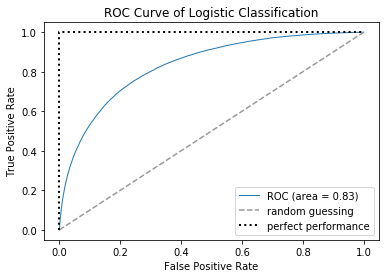

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probas = lr.predict_proba(X_test_pca)
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1], pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,lw =1, label = 'ROC (area = %.2f)' %(roc_auc))
plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')
plt.plot([0,0,1], [0,1,1], lw=2, linestyle = ':', color = 'black', label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Classification')
plt.legend(loc = 'lower right')

The area under curve is 0.83, which means that model is good at predicting the low-risk profitable trading opportunity.

### 5.2. SVM

### 5.3. DNN

#### 5.3.1. Feature Preprocessing
In terms of deep neural network, we use all the features in the training dataset and do standardization before training to increase to traning speed.
To test the accuracy of the model, we train on 80% of the samples and test on 20% of the samples.

In [48]:
X = np.array(traindf[features])
y = np.array(traindf['f_%s_target'%lag])
y = y.reshape((y.shape[0], 1))
x_train, x_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size = 0.2, random_state = 11)
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

#### 5.3.2. DNN Structures after hyperparameter tunning
* We use **keras** package with tensorflow as kernel
* **Sequential** Model is used
* 1 input layer, 11 hidden layers, 1 output layers
* Input and all the hidden layers employ '**ReLu**' activation function
* The output layer employs '**Sigmoid**' activation function
* Parameter cw = {0: 1, 1: 5.32} indicates that we give more weights on '1' label because of the **imbalance dataset**
* The loss function we used in back propagation is '**binary_crossentropy**'
* **Adam optimizer** is used because it considers both momentum effect and avoids gradient exposure

In [51]:
model = Sequential()
model.add(Dense(128, activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
portion = np.sum(traindf['target'] == 0) / np.sum(traindf['target'] == 1)
cw = {0: 1, 1: portion}
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])

* Start training

In [52]:
model.fit(x_train, y_train, epochs=20, batch_size = 1024, class_weight=cw)

Epoch 1/20
277891/277891 [==============================] - 9s 31us/step - loss: 0.9985 - acc: 0.7395
Epoch 2/20
277891/277891 [==============================] - 8s 29us/step - loss: 0.9123 - acc: 0.7475
Epoch 3/20
277891/277891 [==============================] - 8s 30us/step - loss: 0.9060 - acc: 0.7512
Epoch 4/20
277891/277891 [==============================] - 8s 30us/step - loss: 0.9025 - acc: 0.7526
Epoch 5/20
277891/277891 [==============================] - 8s 28us/step - loss: 0.9002 - acc: 0.7521
Epoch 6/20
277891/277891 [==============================] - 9s 31us/step - loss: 0.8988 - acc: 0.7532
Epoch 7/20
277891/277891 [==============================] - 8s 29us/step - loss: 0.8966 - acc: 0.7518
Epoch 8/20
277891/277891 [==============================] - 9s 31us/step - loss: 0.8948 - acc: 0.7529
Epoch 9/20
277891/277891 [==============================] - 9s 31us/step - loss: 0.8935 - acc: 0.7515
Epoch 10/20
277891/277891 [==============================] - 9s 31us/step - loss: 

#### 5.3.3. Model Test
When we are actually trading, we focus on whether we can profit from the model result. If the stock features predict '1', we will buy the stock and wait for profit. Therefore, '**Precision**' the right metric for us to evaluate the model.

Text(0.5,1,'The relationship between change of thresholds and precision')

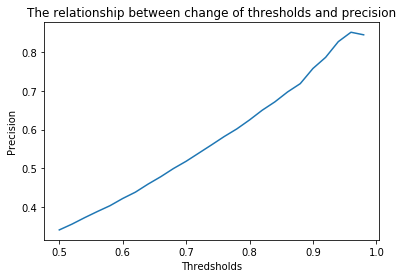

In [60]:
a = model.predict_classes(x_test)
y_pred = model.predict(x_test)
y_probas = model.predict_proba(x_test)
d = model.predict(x_test)
b = [i[0] for i in a]
c = [i[0] for i in y_test]
d = [i[0] for i in d]
testdf = pd.DataFrame({'pred': b, 'prob': d, 'test': c})
testdf = testdf.sort_values(['pred'], ascending = False)
recalllist = []
thredlist = list(range(50, 100, 2))
for i in thredlist:
	tempdf = testdf[testdf['prob'] >= i / 100]
	recalllist.append(sum(tempdf['test'] == 1) / len(tempdf))
thredlist = list(map(lambda x : x / 100, thredlist))
plt.plot(thredlist, recalllist)
plt.xlabel('Thredsholds')
plt.ylabel('Precision')
plt.title('The relationship between change of thresholds and precision')

The result is very encouraging.
We use the trained models to predict out-of-sample data.
The graph above shows that if we increase the thredsholds of predicting labels as 1, the precision increases gradually. We have **75% probability to succeed** if we buy stocks with **model prediction probabilities more than 90%**. 

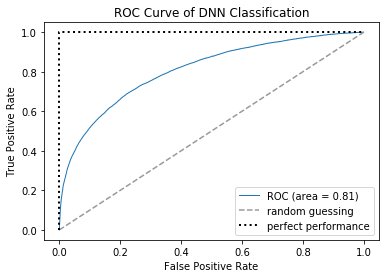

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,lw =1, label = 'ROC (area = %.2f)' %(roc_auc))
plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')
plt.plot([0,0,1], [0,1,1], lw=2, linestyle = ':', color = 'black', label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of DNN Classification')
plt.legend(loc = 'lower right')

In addition, the area under curve is 0.81, which means that model is very good at predicting the low-risk profitable trading opportunity.